In [1]:
! pip install ta
! pip install blitz-bayesian-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=d9bf41c7f984a0afd4be6f9def3ee5ff265f88cf1f43b9c24ad47128d0323575
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/1

Data downloaded. Shape: (9167, 7)
Calculating technical indicators (TA-Lib) with fillna=True...
Adding custom features (lags, returns, volatility, slope, time)...
Filled 31 NaN values introduced by custom features/inf replacement.
Number of features: 101
Data shape after feature engineering and NaN handling: (9167, 102)
Preprocessing data (scaling and sequencing)...
Created sequences. X shape: (9103, 60, 101), y shape: (9103, 5)
Train shapes: X=(7282, 60, 101), y=(7282, 5)
Test shapes:  X=(1821, 60, 101), y=(1821, 5)
Defining Bayesian Neural Network model...
Starting training...
Epoch 1/240, Train Loss (ELBO): 238.037845, Test Loss (MSE): 0.002377
Epoch 2/240, Train Loss (ELBO): 224.317244, Test Loss (MSE): 0.000530
Epoch 3/240, Train Loss (ELBO): 219.589983, Test Loss (MSE): 0.000309
Epoch 4/240, Train Loss (ELBO): 216.776098, Test Loss (MSE): 0.000280
Epoch 5/240, Train Loss (ELBO): 214.358229, Test Loss (MSE): 0.000386
Epoch 6/240, Train Loss (ELBO): 212.024035, Test Loss (MSE): 0.0

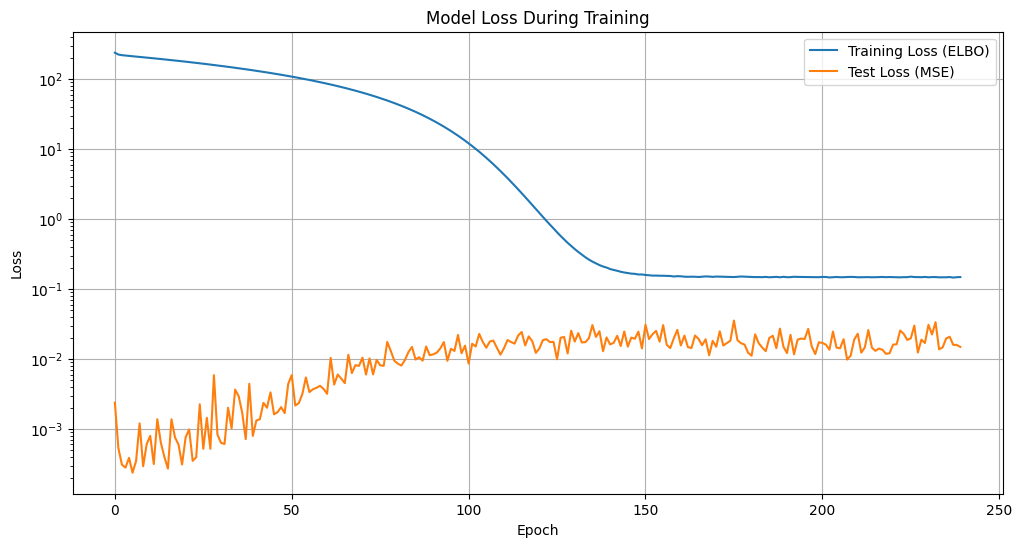

Generating predictions with uncertainty (50 MC samples)...
Visualizing predictions vs actuals with uncertainty...


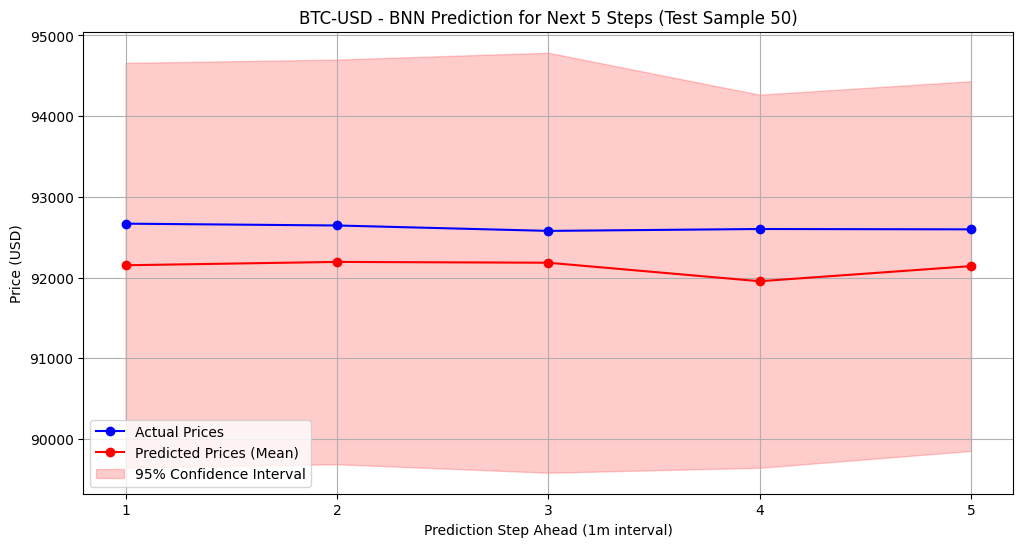

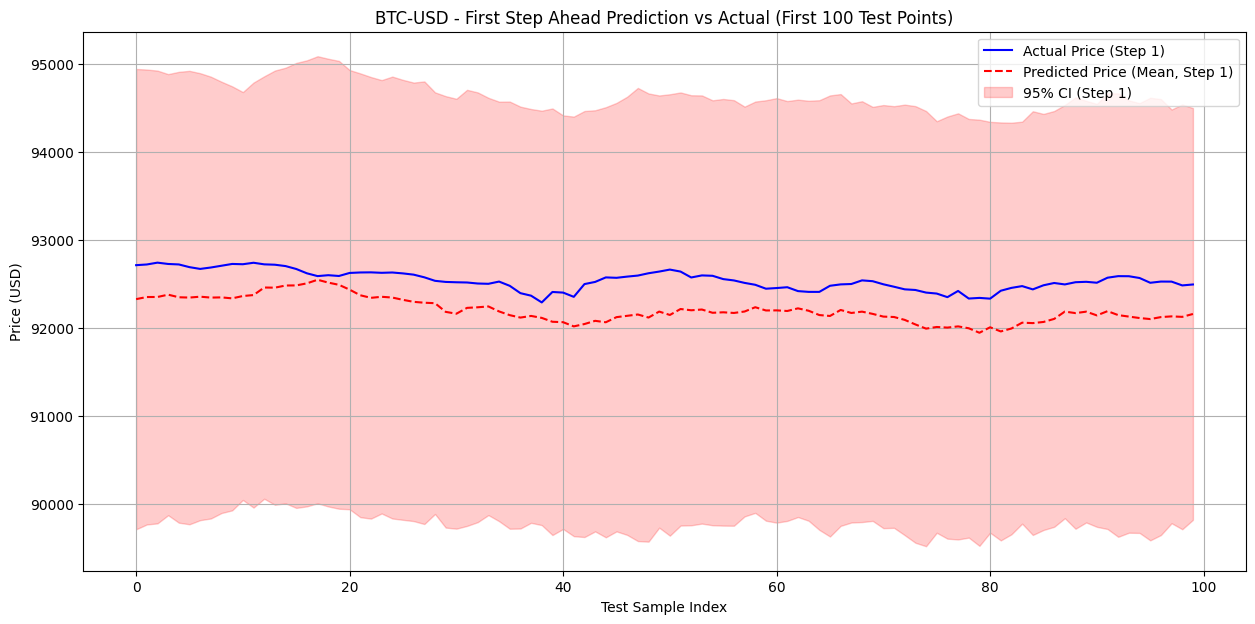


--- Evaluation Metrics (RMSE) ---
RMSE for Step 1: 435.2747
RMSE for Step 2: 399.2020
RMSE for Step 3: 417.8860
RMSE for Step 4: 641.3127
RMSE for Step 5: 467.1617


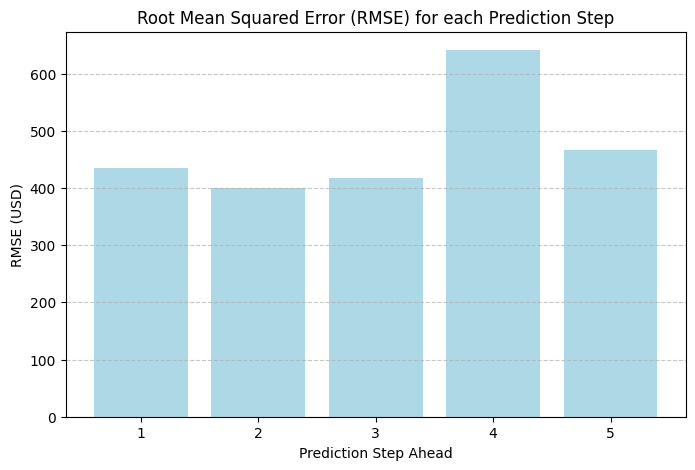

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from ta.utils import dropna # We won't use dropna directly on the whole dataframe anymore
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming blitz is installed: pip install blitz-bayesian-pytorch
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore') # Suppress warnings from ta/yfinance if any

# --- Configuration ---
TICKER = 'BTC-USD'
DATA_PERIOD = '7d' # Max 7 days for 1m interval with 'period', might still be short
INTERVAL = '1m'
SEQUENCE_LENGTH = 60
PREDICTION_HORIZON = 5
N_FEATURES = 0
HIDDEN_UNITS = 64
NUM_MC_SAMPLES = 50
LEARNING_RATE = 0.001
EPOCHS = 240
BATCH_SIZE = 64
TEST_SPLIT_SIZE = 0.2

# --- Configuration for New Features ---
N_LAG_FEATURES = 3
VOLATILITY_WINDOW = 10
SMA_SLOPE_WINDOW = 10

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- 1. Data Loading ---
print(f"Downloading {TICKER} data ({DATA_PERIOD}, {INTERVAL})...")
try:
    # Consider using start/end if you need more than 7 days, but beware yfinance 1m limitations
    # Example:
    # from datetime import datetime, timedelta
    # end_date = datetime.now()
    # start_date = end_date - timedelta(days=10) # Request 10 days
    # data = yf.Ticker(TICKER).history(start=start_date, end=end_date, interval=INTERVAL, auto_adjust=True)

    data = yf.Ticker(TICKER).history(period=DATA_PERIOD, interval=INTERVAL, auto_adjust=True)

    if data.empty:
        raise ValueError(f"No data downloaded for {TICKER}. Check ticker, period/dates, and interval ('1m' data has limitations).")
    print(f"Data downloaded. Shape: {data.shape}")
    data.index = pd.to_datetime(data.index)
    if data.index.tz is None:
        try:
            data.index = data.index.tz_localize('UTC')
            # print("Localized index to UTC.") # Keep if useful
        except TypeError:
            pass
    elif data.index.tz != 'UTC':
         # print(f"Warning: Index timezone is {data.index.tz}. Forcing UTC.") # Keep if useful
         data.index = data.index.tz_convert('UTC')

    if 'Close' not in data.columns:
        raise ValueError("'Close' column not found in downloaded data.")
    target_col = 'Close'

except Exception as e:
    print(f"Error downloading data: {e}")
    exit()

# --- 2. Feature Engineering ---
print("Calculating technical indicators (TA-Lib) with fillna=True...")
# *** CHANGE 1: Use fillna=True ***
data = ta.add_all_ta_features(
    data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)

print("Adding custom features (lags, returns, volatility, slope, time)...")
# Add Lagged Close Prices
for i in range(1, N_LAG_FEATURES + 1):
    data[f'Close_lag_{i}'] = data[target_col].shift(i)

# Add Lagged Returns
for i in range(1, N_LAG_FEATURES + 1):
    data[f'Return_lag_{i}'] = data[target_col].pct_change(periods=i) * 100

# Add Rolling Volatility (Standard Deviation)
data[f'Volatility_{VOLATILITY_WINDOW}'] = data[target_col].rolling(window=VOLATILITY_WINDOW).std()

# Add Moving Average Slope
sma = data[target_col].rolling(window=SMA_SLOPE_WINDOW).mean()
data[f'SMA_{SMA_SLOPE_WINDOW}_Slope'] = sma.diff()

# Add Time Features
data['Hour'] = data.index.hour

# Replace infinite values that might arise from pct_change(0) or divisions
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# *** CHANGE 2: Explicitly fill NaNs introduced by custom features ***
# Use bfill first to fill using next valid observation, then ffill for any remaining at the start
initial_nans = data.isnull().sum().sum()
data.fillna(method='bfill', inplace=True)
data.fillna(method='ffill', inplace=True)
filled_nans = initial_nans - data.isnull().sum().sum()
print(f"Filled {filled_nans} NaN values introduced by custom features/inf replacement.")

# *** CHANGE 3: Remove or comment out the dropna call ***
# initial_len = len(data)
# data = data.dropna()
# print(f"Removed {initial_len - len(data)} rows with NaNs after all feature calculations.") # No longer dropping rows


# --- Check if enough data remains ---
# We check *before* separating features/target, as data length is now stable
if len(data) < SEQUENCE_LENGTH + PREDICTION_HORIZON:
     print(f"Error: Not enough data ({len(data)} rows) after loading and feature calculation "
           f"to create sequences of length {SEQUENCE_LENGTH} + {PREDICTION_HORIZON}.")
     print(f"Consider using a longer DATA_PERIOD (may require start/end dates), "
           f"a shorter SEQUENCE_LENGTH, or fewer lagged/rolling features.")
     # If you still hit this, it means even 7d of 1m data isn't enough for your sequence/horizon/windows.
     # You *must* fetch more data or reduce sequence/window requirements.
     exit()


# Separate features and target *after* all features are created and NaNs handled
if target_col not in data.columns:
    raise ValueError(f"Target column '{target_col}' is missing after feature engineering.")

data[target_col] = data[target_col].astype(float)

features_df = data.drop(columns=[target_col])
target_series = data[target_col]
N_FEATURES = features_df.shape[1]

# Convert boolean features (often generated by TA-lib) to integers
bool_cols = features_df.select_dtypes(include='bool').columns
features_df[bool_cols] = features_df[bool_cols].astype(int)

print(f"Number of features: {N_FEATURES}")
print(f"Data shape after feature engineering and NaN handling: {data.shape}") # Add print


# --- 3. Data Preprocessing ---
print("Preprocessing data (scaling and sequencing)...")
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Ensure all feature columns are numeric before scaling
numeric_feature_cols = features_df.select_dtypes(include=np.number).columns
if len(numeric_feature_cols) != N_FEATURES:
    print("Warning: Non-numeric columns found in features. Attempting to scale only numeric ones.")
    print("Non-numeric columns:", features_df.select_dtypes(exclude=np.number).columns.tolist())
    scaled_features = feature_scaler.fit_transform(features_df[numeric_feature_cols])
else:
     # Now this should work as features_df is no longer empty
     scaled_features = feature_scaler.fit_transform(features_df)


scaled_target = target_scaler.fit_transform(target_series.values.reshape(-1, 1))

X, y = [], []
if len(scaled_features) < SEQUENCE_LENGTH + PREDICTION_HORIZON:
     print(f"Error: Scaled features length ({len(scaled_features)}) insufficient for sequence creation.")
     exit()

for i in range(len(scaled_features) - SEQUENCE_LENGTH - PREDICTION_HORIZON + 1):
    X.append(scaled_features[i : i + SEQUENCE_LENGTH])
    y.append(scaled_target[i + SEQUENCE_LENGTH : i + SEQUENCE_LENGTH + PREDICTION_HORIZON].flatten())
X = np.array(X)
y = np.array(y)

print(f"Created sequences. X shape: {X.shape}, y shape: {y.shape}")
if X.shape[0] == 0:
    print("Error: No sequences were created. Check data length and sequence parameters.")
    exit()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SPLIT_SIZE, random_state=42, shuffle=False
)
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes:  X={X_test.shape}, y={y_test.shape}")

if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    print("Error: Training or testing set is empty after split. Check data length and TEST_SPLIT_SIZE.")
    exit()


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# --- 4. Bayesian Neural Network Model ---
# (Model Definition remains the same)
print("Defining Bayesian Neural Network model...")

@variational_estimator
class BayesianStockPredictor(nn.Module):
    def __init__(self, input_features, hidden_units, output_steps, sequence_length):
        super().__init__()
        self.input_features = input_features
        self.sequence_length = sequence_length

        self.flatten = nn.Flatten()
        flattened_input_size = input_features * sequence_length

        self.blinear1 = BayesianLinear(flattened_input_size, hidden_units)
        self.relu1 = nn.ReLU()
        self.blinear2 = BayesianLinear(hidden_units, hidden_units // 2)
        self.relu2 = nn.ReLU()
        self.blinear3 = BayesianLinear(hidden_units // 2, output_steps)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.blinear1(x))
        x = self.relu2(self.blinear2(x))
        x = self.blinear3(x)
        return x

model = BayesianStockPredictor(N_FEATURES, HIDDEN_UNITS, PREDICTION_HORIZON, SEQUENCE_LENGTH)


# --- 5. Training ---
# (Training loop remains the same)
# --- 5. Training ---
print("Starting training...")

criterion = nn.MSELoss() # Loss function for the NLL part of ELBO
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = [] # Stores ELBO loss from sample_elbo
test_losses = []  # Stores MSE loss for evaluation

# No need to explicitly list bayesian_layers if using sample_elbo

# Determine the weight for the complexity cost (KL divergence)
# Common practice is 1 / N, where N is the total number of training samples
complexity_weight = 1.0 / len(train_loader.dataset)

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0

    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        # --- Use sample_elbo to calculate the loss ---
        # It computes NLL using the criterion and adds the scaled KL divergence
        # sample_nbr=3 : Uses 3 samples of weights to estimate ELBO for the batch. More samples = more stable estimate but slower. 1 is often okay.
        loss = model.sample_elbo(inputs=inputs,
                                 labels=targets,
                                 criterion=criterion,
                                 sample_nbr=3, # You can adjust this (e.g., 1 or 5)
                                 complexity_cost_weight=complexity_weight)

        loss.backward()
        optimizer.step()

        # Accumulate loss correctly - sample_elbo returns loss for the batch
        epoch_train_loss += loss.item() * inputs.size(0) # Multiply by batch size to get total loss for batch

    # Average the loss over the entire dataset
    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation/Test Loss (using standard MSE for evaluation) ---
    model.eval()
    epoch_test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            # For evaluation, usually use a single forward pass (mean prediction)
            outputs = model(inputs)
            loss_test_mse = criterion(outputs, targets)
            epoch_test_loss += loss_test_mse.item() * inputs.size(0) # Accumulate total MSE

    epoch_test_loss /= len(test_loader.dataset) # Average MSE per sample
    test_losses.append(epoch_test_loss)

    # Reporting: Train loss is ELBO, Test loss is MSE
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss (ELBO): {epoch_train_loss:.6f}, Test Loss (MSE): {epoch_test_loss:.6f}")

print("Training finished.")

# --- 6. Plotting Training History ---
# (Plotting remains the same)
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss (ELBO)')
plt.plot(test_losses, label='Test Loss (MSE)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()


# --- 7. Prediction with Uncertainty (Monte Carlo Sampling) ---
# (Prediction remains the same)
print(f"Generating predictions with uncertainty ({NUM_MC_SAMPLES} MC samples)...")
model.eval()
mc_predictions = []

with torch.no_grad():
    for _ in range(NUM_MC_SAMPLES):
        y_pred_mc = model(X_test_tensor)
        mc_predictions.append(y_pred_mc.cpu().numpy())

mc_predictions = np.stack(mc_predictions, axis=0)
pred_mean = np.mean(mc_predictions, axis=0)
pred_std = np.std(mc_predictions, axis=0)

pred_mean_orig = target_scaler.inverse_transform(pred_mean)
pred_std_orig = pred_std * (target_scaler.data_max_ - target_scaler.data_min_)
y_test_orig = target_scaler.inverse_transform(y_test)

# --- 8. Evaluation & Visualization ---
# (Evaluation and Visualization remain the same)
print("Visualizing predictions vs actuals with uncertainty...")
from sklearn.metrics import mean_squared_error # Make sure import is here

if len(y_test_orig) > 50:
    sample_idx = 50
else:
    sample_idx = len(y_test_orig) - 1

if sample_idx >= len(y_test_orig):
    print(f"Warning: sample_idx {sample_idx} is out of bounds for test set size {len(y_test_orig)}. Adjusting.")
    sample_idx = max(0, len(y_test_orig) - 1) # Ensure sample_idx is non-negative

# Check if test set is empty before indexing
if len(y_test_orig) > 0:
    pred_steps_mean = pred_mean_orig[sample_idx, :]
    pred_steps_std = pred_std_orig[sample_idx, :]
    actual_steps = y_test_orig[sample_idx, :]
    time_steps = np.arange(PREDICTION_HORIZON) + 1

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, actual_steps, 'bo-', label='Actual Prices')
    plt.plot(time_steps, pred_steps_mean, 'ro-', label='Predicted Prices (Mean)')
    plt.fill_between(time_steps,
                     pred_steps_mean - 1.96 * pred_steps_std,
                     pred_steps_mean + 1.96 * pred_steps_std,
                     color='r', alpha=0.2, label='95% Confidence Interval')
    plt.title(f'{TICKER} - BNN Prediction for Next {PREDICTION_HORIZON} Steps (Test Sample {sample_idx})')
    plt.xlabel(f'Prediction Step Ahead ({INTERVAL} interval)')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(time_steps)
    plt.show()

    num_points_to_plot = 100
    plot_limit = min(num_points_to_plot, len(y_test_orig))
    time_axis_test = np.arange(plot_limit)

    plt.figure(figsize=(15, 7))
    plt.plot(time_axis_test, y_test_orig[:plot_limit, 0], label='Actual Price (Step 1)', color='blue', linewidth=1.5)
    plt.plot(time_axis_test, pred_mean_orig[:plot_limit, 0], label='Predicted Price (Mean, Step 1)', color='red', linestyle='--', linewidth=1.5)
    plt.fill_between(time_axis_test,
                     pred_mean_orig[:plot_limit, 0] - 1.96 * pred_std_orig[:plot_limit, 0],
                     pred_mean_orig[:plot_limit, 0] + 1.96 * pred_std_orig[:plot_limit, 0],
                     color='red', alpha=0.2, label='95% CI (Step 1)')
    plt.title(f'{TICKER} - First Step Ahead Prediction vs Actual (First {plot_limit} Test Points)')
    plt.xlabel('Test Sample Index')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    rmse_steps = []
    print("\n--- Evaluation Metrics (RMSE) ---")
    for i in range(PREDICTION_HORIZON):
        rmse = np.sqrt(mean_squared_error(y_test_orig[:, i], pred_mean_orig[:, i]))
        rmse_steps.append(rmse)
        print(f"RMSE for Step {i+1}: {rmse:.4f}")

    plt.figure(figsize=(8, 5))
    plt.bar(time_steps, rmse_steps, color='lightblue')
    plt.title('Root Mean Squared Error (RMSE) for each Prediction Step')
    plt.xlabel('Prediction Step Ahead')
    plt.ylabel('RMSE (USD)')
    plt.xticks(time_steps)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Test set is empty, skipping detailed visualization and evaluation.")